In [10]:
% run 0-utils.ipynb

icebergs = pd.read_json('../data/train.json').set_index('id')
icebergs = icebergs.assign(
    inc_angle=pd.to_numeric(icebergs.inc_angle, 'coerce'),
    band_1=icebergs.band_1.apply(np.array),
    band_2=icebergs.band_2.apply(np.array),
)
icebergs.head()



def load_test_set():
    icebergs = pd.read_json('../data/test.json').set_index('id')
    icebergs = icebergs.assign(
        inc_angle=pd.to_numeric(icebergs.inc_angle, 'coerce'),
        band_1=icebergs.band_1.apply(np.array),
        band_2=icebergs.band_2.apply(np.array),
    )
    return icebergs



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
% run 4-graph-utils.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import scipy.sparse.csgraph
from tensorboardX import SummaryWriter
import skimage.transform as transform
import networkx as nx
from scipy import spatial

In [13]:
#from pygsp.reduction import graph_sparsify#, kron_reduction
from pygsp import graphs, filters, utils
from scipy.sparse.linalg import eigsh
from scipy.sparse import linalg
from scipy import sparse, stats
from scipy.sparse.csgraph import minimum_spanning_tree, dijkstra

In [14]:
from pyamg import smoothed_aggregation_solver

In [15]:
icebergs.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


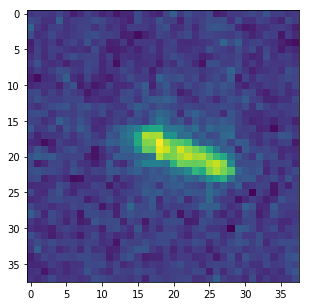

In [16]:
test = transform.rescale(icebergs.band_1.iloc[100].reshape(75, 75), 0.5, mode='constant')
plt.imshow(test);

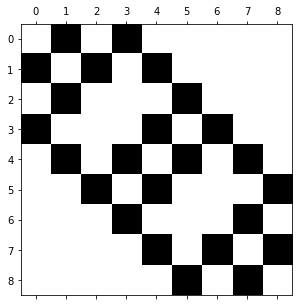

In [17]:
plt.spy(distance(grid(3), k=1, metric='cityblock'));

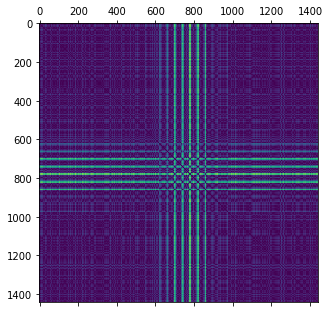

In [18]:
test_dist = spatial.distance.squareform(spatial.distance.pdist(test.reshape(-1, 1), metric='euclidean'))
plt.matshow(test_dist);

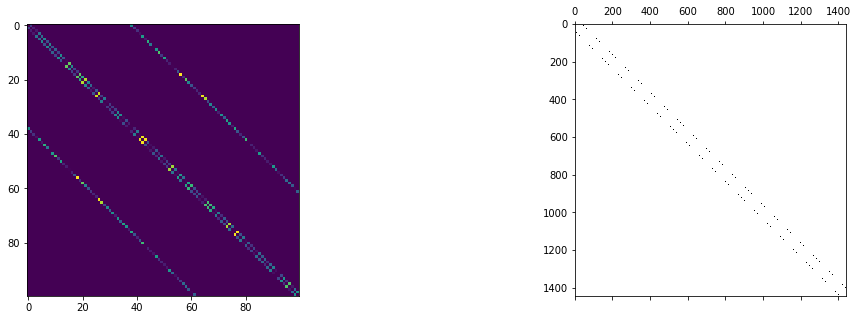

In [19]:
test_dist[np.where(distance(grid(38), k=2) == 0)] = 0

plt.subplot(121)
plt.imshow(test_dist[:100, :100])

plt.subplot(122)
plt.spy(test_dist);

In [149]:
def calc_weight(n, root, pred, local_tree):
    
    if n==root:
        return 0, root, root
    
    parent = pred[root, n]

    w_p = local_tree[parent, n]
    
    gparent = pred[root, parent]
    
    if gparent != -9999:
        w_d = local_tree[gparent, parent]
    else:
        w_d = 1
        gparent = n
        
    w = 2./(1./w_p + 1./w_d)

    return w, parent, gparent

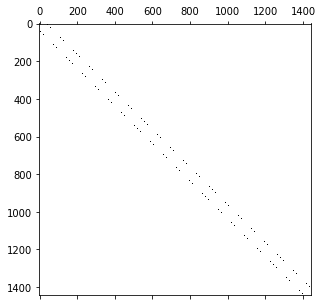

In [21]:
plt.spy(test_dist)

In [155]:
result, array = one_level_MST(test_dist)

In [156]:
p = pd.DataFrame(array)
pd.DataFrame(p[0].value_counts()).sort_values(0, ascending=False)

,0
-1,722
700,1
712,1
720,1
719,1
718,1
717,1
716,1
715,1
714,1


In [154]:
def one_level_MST(test_dist):

    test_dist_triu = np.triu(test_dist)
    Tree = minimum_spanning_tree(test_dist_triu)
    Tree = Tree + Tree.T
    local_tree = Tree.todense()

    distance_matrix, pred = dijkstra(Tree.todense(), directed=False, unweighted=True, return_predecessors=True)

    root = np.random.choice(np.arange(distance_matrix.shape[0]))
    even_nodes = distance_matrix[:, root] % 2 == 0
    even_nodes = np.arange(1444)[even_nodes]

    weight_tree = np.zeros((int(local_tree.shape[0]/2), int(local_tree.shape[1]/2)))
    
    array = [-1]*local_tree.shape[0]
    cluster = 0
    
    for n in even_nodes:
        new_weight, parent, gparent = calc_weight(n, root, pred, local_tree)
        array[n] = cluster
        array[parent] = cluster
        cluster += 1
        
        n = int(n/2)
        out_div = int(gparent/2)
        weight_tree[n, out_div] = new_weight
        weight_tree[out_div, n] = new_weight
        
    return weight_tree, array


In [ ]:
G = graphs.Graph(Tree)
G.set_coordinates()
G.plot()

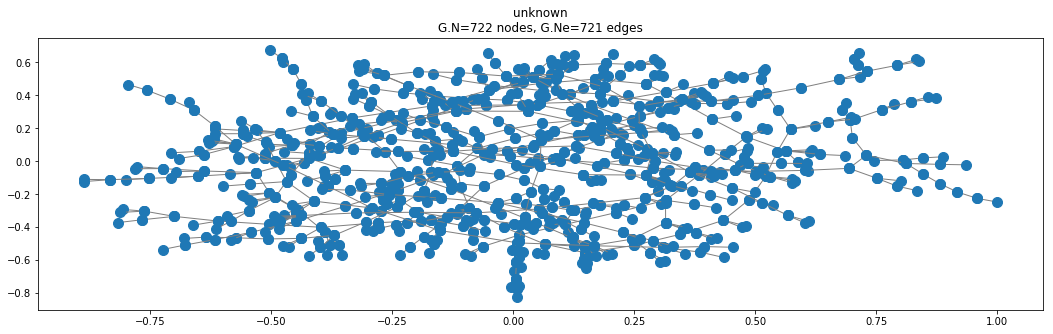

In [153]:
G2 = graphs.Graph(result)
G2.set_coordinates()
G2.plot()

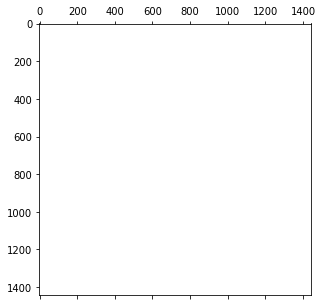

In [52]:
plt.spy(weight_tree)

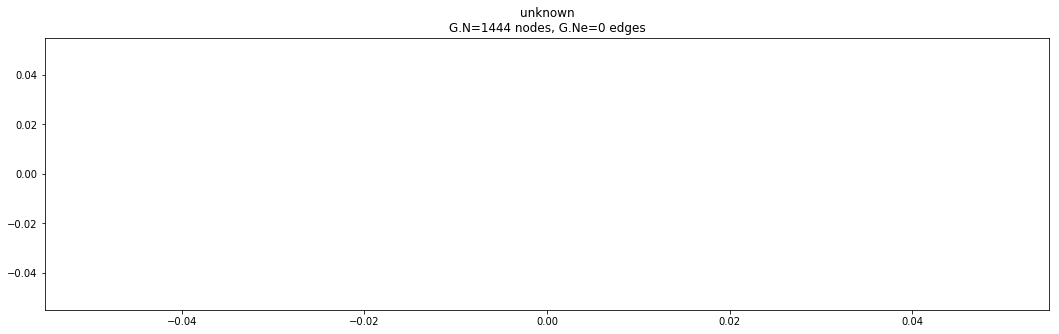

In [53]:
G1 = graphs.Graph(weight_tree)
G1.set_coordinates()
G1.plot()

In [ ]:
G = sp.sparse.csr.csr_matrix(distance(grid(4), 1, metric='cityblock'))

In [ ]:
plt.spy(G.todense())

In [ ]:
graph, perm = coarsen(G, levels=2, self_connections=False)

In [ ]:
perm

In [ ]:
for g in graph:
    plt.subplot(121)
    plt.spy(g.todense())
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g.todense()))
    plt.show()

In [ ]:
gr = grid(38)
gr.shape

In [ ]:
mask = distance(gr, k=3) > 0
plt.spy(mask[:40, :40]);

In [ ]:
graph, perm = coarsen(sp.sparse.csr.csr_matrix(mask), levels=3, self_connections=False)